In [1]:
!pip install polars

In [2]:
import polars as pl
import pandas as pd
import numpy as np
from functools import reduce
import re
import matplotlib.pyplot as plt

### Xử lí 4 phase và gộp 4 phase

In [3]:
uv_phase_1 = pl.read_parquet("/kaggle/input/uv-2weeks-phase1/user_video_phase.parquet")
uv_phase_2 = pl.read_parquet("/kaggle/input/uv-2weeks-phase2/user_video_phase2.parquet")
uv_phase_3 = pl.read_parquet("/kaggle/input/uv-2weeks-phase3/user_video_phase3.parquet")
uv_phase_4 = pl.read_parquet("/kaggle/input/uv-2weeks-phase4/user_video_phase4.parquet")
#uv_phase_2.head()

In [4]:
#Đổi tên lại các cột
# Đổi tên tất cả các cột kết thúc bằng _1 thành _2

uv_phase_2 = uv_phase_2.rename({
    col: col.replace("_1", "_2") for col in uv_phase_2.columns if col.endswith("_1")
})

uv_phase_3 = uv_phase_3.rename({
    col: col.replace("_1", "_3") for col in uv_phase_3.columns if col.endswith("_1")
})

uv_phase_4 = uv_phase_4.rename({
    col: col.replace("_1", "_4") for col in uv_phase_4.columns if col.endswith("_1")
})



In [5]:
print(f"Phase 1 có {uv_phase_1.shape[0]} user")
print(f"Phase 2 có {uv_phase_2.shape[0]} user")
print(f"Phase 3 có {uv_phase_3.shape[0]} user")
print(f"Phase 4 có {uv_phase_4.shape[0]} user")

Phase 1 có 23441 user
Phase 2 có 9911 user
Phase 3 có 5575 user
Phase 4 có 3632 user


In [6]:
uv_phase_2.columns

['user_id',
 'course_of_watched_video',
 'ccid',
 'enroll_time',
 'video_length',
 'local_start_time',
 'duration_seg',
 'segments_list',
 'start_points',
 'end_points',
 'speed',
 'watch_time_seg',
 'video_watch_count_2',
 'unique_course',
 'total_videos_for_user',
 'video_watched_percentage_2',
 'video_percentage_watch_time_2',
 'video_pause_count_2',
 'video_pause_avg_2',
 'video_pause_std_2',
 'video_rewatch_count_2',
 'video_rewatch_avg_2',
 'video_rewatch_std_2',
 'video_time_between_views_2',
 'video_time_between_views_avg_2',
 'video_time_between_views_std_2',
 'video_speed_avg_2',
 'ent_seg',
 'entropy_time_2']

In [7]:
# Hàm lọc chỉ các cột có đuôi theo phase và cột "user_id"
def filter_columns_by_suffix(df, suffix):
    return df.select([col for col in df.columns if col == "user_id" or col.endswith(suffix)])

# Lọc các cột theo đúng phase
df_phase_1_filtered = filter_columns_by_suffix(uv_phase_1, "_1")
df_phase_2_filtered = filter_columns_by_suffix(uv_phase_2, "_2")
df_phase_3_filtered = filter_columns_by_suffix(uv_phase_3, "_3")
df_phase_4_filtered = filter_columns_by_suffix(uv_phase_4, "_4")

# Join từng bước và xử lý cột user_id bị trùng
df_join_1_2 = df_phase_1_filtered.join(df_phase_2_filtered, on="user_id", how="full")

# Xử lý user_id bị rename nếu có
df_join_1_2 = df_join_1_2.with_columns([
    pl.coalesce(["user_id", "user_id_right"]).alias("user_id")
]).drop(["user_id_right"])

# Tiếp tục join với phase 3
df_join_1_2_3 = df_join_1_2.join(df_phase_3_filtered, on="user_id", how="full")
df_join_1_2_3 = df_join_1_2_3.with_columns([
    pl.coalesce(["user_id", "user_id_right"]).alias("user_id")
]).drop(["user_id_right"])

# Join với phase 4
df_all_phases = df_join_1_2_3.join(df_phase_4_filtered, on="user_id", how="full")
df_all_phases = df_all_phases.with_columns([
    pl.coalesce(["user_id", "user_id_right"]).alias("user_id")
]).drop(["user_id_right"])


In [8]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Chuyển sang pandas
# df_all_phases = df_all_phases.select(["video_watched_percentage_1"]).to_pandas()

# # Vẽ histogram
# plt.figure(figsize=(8, 5))
# sns.histplot(df_all_phases["video_watched_percentage_1"], bins=30, kde=True, color='skyblue')
# plt.title("Phân bố phần trăm video đã xem")
# plt.xlabel("Phần trăm video đã xem (%)")
# plt.ylabel("Số lượng người dùng")
# plt.grid(True)
# plt.show()


In [9]:
df_all_phases.shape

(32854, 57)

In [10]:
df_all_phases[:2, :]

user_id,video_watch_count_1,video_watched_percentage_1,video_percentage_watch_time_1,video_pause_count_1,video_pause_avg_1,video_pause_std_1,video_rewatch_count_1,video_rewatch_avg_1,video_rewatch_std_1,video_time_between_views_1,video_time_between_views_avg_1,video_time_between_views_std_1,video_speed_avg_1,entropy_time_1,video_watch_count_2,video_watched_percentage_2,video_percentage_watch_time_2,video_pause_count_2,video_pause_avg_2,video_pause_std_2,video_rewatch_count_2,video_rewatch_avg_2,video_rewatch_std_2,video_time_between_views_2,video_time_between_views_avg_2,video_time_between_views_std_2,video_speed_avg_2,entropy_time_2,video_watch_count_3,video_watched_percentage_3,video_percentage_watch_time_3,video_pause_count_3,video_pause_avg_3,video_pause_std_3,video_rewatch_count_3,video_rewatch_avg_3,video_rewatch_std_3,video_time_between_views_3,video_time_between_views_avg_3,video_time_between_views_std_3,video_speed_avg_3,entropy_time_3,video_watch_count_4,video_watched_percentage_4,video_percentage_watch_time_4,video_pause_count_4,video_pause_avg_4,video_pause_std_4,video_rewatch_count_4,video_rewatch_avg_4,video_rewatch_std_4,video_time_between_views_4,video_time_between_views_avg_4,video_time_between_views_std_4,video_speed_avg_4,entropy_time_4
str,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64
"""U_24869016""",1,2.380952,4.451426,2,2.0,0.0,[1],1.0,0.0,[[-1.1]],-1.1,0.0,1.0,0.745353,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""U_28951047""",1,1.162791,13.509049,5,5.0,0.0,[0],0.0,0.0,"[[5.067, 390.008, … 5.006]]",101.272,192.490669,1.0,2.045522,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [11]:
df_all_phases.columns

['user_id',
 'video_watch_count_1',
 'video_watched_percentage_1',
 'video_percentage_watch_time_1',
 'video_pause_count_1',
 'video_pause_avg_1',
 'video_pause_std_1',
 'video_rewatch_count_1',
 'video_rewatch_avg_1',
 'video_rewatch_std_1',
 'video_time_between_views_1',
 'video_time_between_views_avg_1',
 'video_time_between_views_std_1',
 'video_speed_avg_1',
 'entropy_time_1',
 'video_watch_count_2',
 'video_watched_percentage_2',
 'video_percentage_watch_time_2',
 'video_pause_count_2',
 'video_pause_avg_2',
 'video_pause_std_2',
 'video_rewatch_count_2',
 'video_rewatch_avg_2',
 'video_rewatch_std_2',
 'video_time_between_views_2',
 'video_time_between_views_avg_2',
 'video_time_between_views_std_2',
 'video_speed_avg_2',
 'entropy_time_2',
 'video_watch_count_3',
 'video_watched_percentage_3',
 'video_percentage_watch_time_3',
 'video_pause_count_3',
 'video_pause_avg_3',
 'video_pause_std_3',
 'video_rewatch_count_3',
 'video_rewatch_avg_3',
 'video_rewatch_std_3',
 'video_tim

In [12]:
# Đếm số lượng null theo từng cột trong df_all_phases
null_counts_per_column = df_all_phases.select(
    [pl.col(c).is_null().sum().alias(c) for c in df_all_phases.columns]
)

null_counts_per_column

user_id,video_watch_count_1,video_watched_percentage_1,video_percentage_watch_time_1,video_pause_count_1,video_pause_avg_1,video_pause_std_1,video_rewatch_count_1,video_rewatch_avg_1,video_rewatch_std_1,video_time_between_views_1,video_time_between_views_avg_1,video_time_between_views_std_1,video_speed_avg_1,entropy_time_1,video_watch_count_2,video_watched_percentage_2,video_percentage_watch_time_2,video_pause_count_2,video_pause_avg_2,video_pause_std_2,video_rewatch_count_2,video_rewatch_avg_2,video_rewatch_std_2,video_time_between_views_2,video_time_between_views_avg_2,video_time_between_views_std_2,video_speed_avg_2,entropy_time_2,video_watch_count_3,video_watched_percentage_3,video_percentage_watch_time_3,video_pause_count_3,video_pause_avg_3,video_pause_std_3,video_rewatch_count_3,video_rewatch_avg_3,video_rewatch_std_3,video_time_between_views_3,video_time_between_views_avg_3,video_time_between_views_std_3,video_speed_avg_3,entropy_time_3,video_watch_count_4,video_watched_percentage_4,video_percentage_watch_time_4,video_pause_count_4,video_pause_avg_4,video_pause_std_4,video_rewatch_count_4,video_rewatch_avg_4,video_rewatch_std_4,video_time_between_views_4,video_time_between_views_avg_4,video_time_between_views_std_4,video_speed_avg_4,entropy_time_4
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,9337,9337,9337,9337,9337,9337,9337,9337,9337,9337,9337,9337,9337,9337,22835,22835,22835,22835,22835,22835,22835,22835,22835,22835,22835,22835,22835,22835,27182,27182,27182,27182,27182,27182,27182,27182,27182,27182,27182,27182,27182,27182,29169,29169,29169,29169,29169,29169,29169,29169,29169,29169,29169,29169,29169,29169


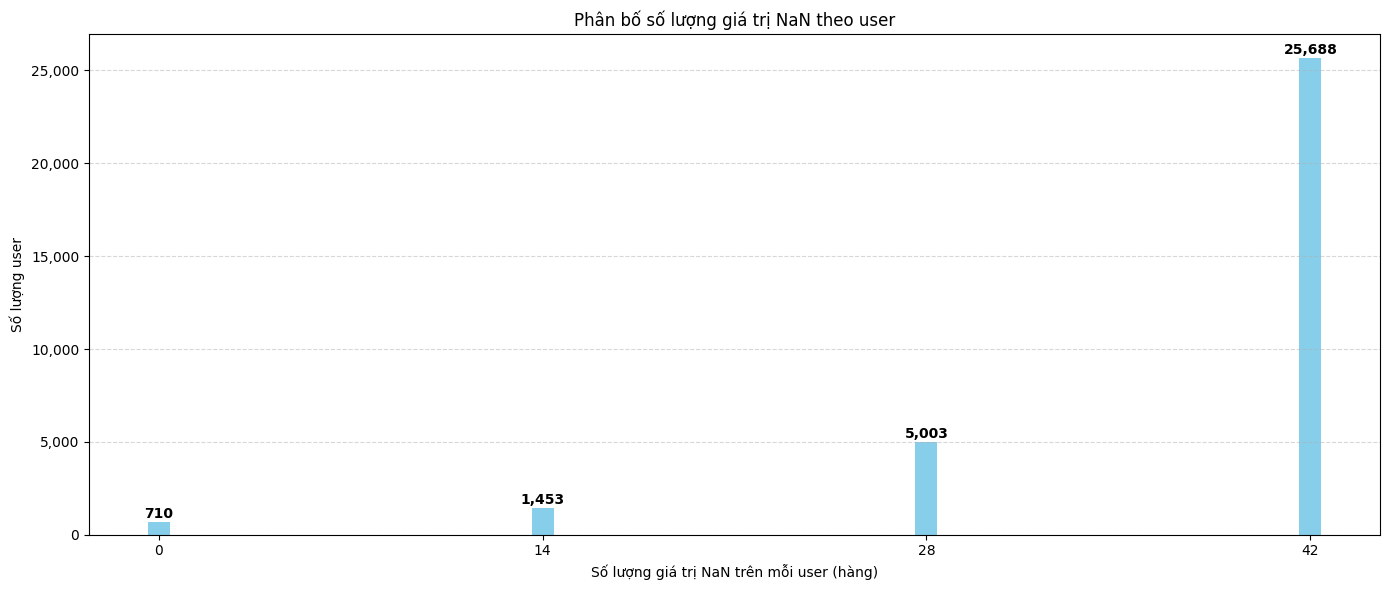

In [13]:
# 1. Tính số lượng giá trị null trên mỗi hàng
df_null_counts = df_all_phases.with_columns(
    pl.sum_horizontal([
        pl.when(pl.col(c).is_null()).then(1).otherwise(0)
        for c in df_all_phases.columns if c != "user_id"
    ]).alias("null_count")
)

# 2. Đếm số lượng user theo số lượng null
df_null_hist = (
    df_null_counts
    .group_by("null_count")
    .len()
    .sort("null_count")
)

# 3. Plot
x = df_null_hist["null_count"].to_list()
y = df_null_hist["len"].to_list()

plt.figure(figsize=(14, 6))
bars = plt.bar(x, y, color="skyblue")
plt.xlabel("Số lượng giá trị NaN trên mỗi user (hàng)")
plt.ylabel("Số lượng user")
plt.title("Phân bố số lượng giá trị NaN theo user")
plt.xticks(x)
# Thêm giá trị vào trên các thanh trong biểu đồ
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50,  # Điều chỉnh vị trí để không bị đè lên thanh
             f'{int(yval):,}', ha='center', va='bottom', fontweight='bold')

# Cập nhật trục tung để dễ đọc số
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Điều chỉnh độ chia trục tung sao cho hợp lý
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


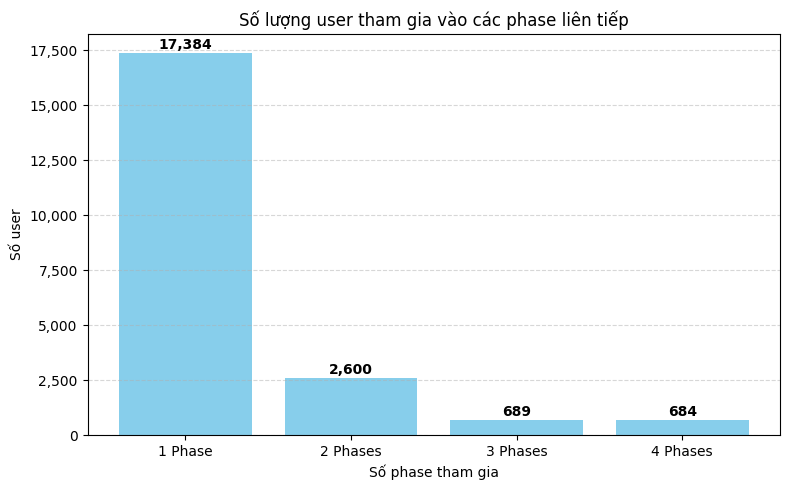

In [14]:
# biểu đồ thể hiện số lượng user tham gia vào các phase khác nhau,
# ví dụ như user tham gia cả ba phase sẽ được tính vào cột "Phase 1, 2, 3"

# Lấy danh sách user_id tham gia ở mỗi phase
users_phase_1 = set(df_phase_1_filtered["user_id"].to_list())
users_phase_2 = set(df_phase_2_filtered["user_id"].to_list())
users_phase_3 = set(df_phase_3_filtered["user_id"].to_list())
users_phase_4 = set(df_phase_4_filtered["user_id"].to_list())

# Tạo các nhóm user tham gia vào các phase
group_1 = len(users_phase_1 - (users_phase_2 | users_phase_3 | users_phase_4))  # Tham gia 1 phase
group_2 = len((users_phase_1 & users_phase_2) - (users_phase_3 | users_phase_4))  # Tham gia 2 phase
group_3 = len((users_phase_1 & users_phase_2 & users_phase_3) - users_phase_4)  # Tham gia 3 phase
group_4 = len(users_phase_1 & users_phase_2 & users_phase_3 & users_phase_4)  # Tham gia 4 phase

# Dữ liệu vẽ biểu đồ
groups = ['1 Phase', '2 Phases', '3 Phases', '4 Phases']
counts = [group_1, group_2, group_3, group_4]

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
bars = plt.bar(groups, counts, color='skyblue')
plt.title("Số lượng user tham gia vào các phase liên tiếp")
plt.ylabel("Số user")
plt.xlabel("Số phase tham gia")

# Thêm giá trị vào trên các thanh trong biểu đồ
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50,  # Điều chỉnh vị trí để không bị đè lên thanh
             f'{int(yval):,}', ha='center', va='bottom', fontweight='bold')

# Cập nhật trục tung để dễ đọc số
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Điều chỉnh độ chia trục tung sao cho hợp lý
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển sang pandas
uv_df1 = uv_phase_1.select(["video_watched_percentage_1"]).to_pandas()
uv_df2 = uv_phase_2.select(["video_percentage_watch_time_2"]).to_pandas()

# Vẽ histogram
plt.figure(figsize=(8, 5))
sns.histplot(uv_df1["video_watched_percentage_1"], bins=30, kde=True, color='skyblue')
plt.title("Phân bố phần trăm video đã xem")
plt.xlabel("Phần trăm video đã xem (%)")
plt.ylabel("Số lượng người dùng")
plt.grid(True)
plt.show()

# Vẽ histogram
plt.figure(figsize=(8, 5))
sns.histplot(uv_df2["video_percentage_watch_time_2"], bins=30, kde=True, color='skyblue')
plt.title("Phân bố phần trăm video đã xem")
plt.xlabel("Phần trăm video đã xem (%)")
plt.ylabel("Số lượng người dùng")
plt.grid(True)
plt.show()


### Xử lí tổng quát user_video

In [15]:
uv_df = pl.read_parquet("/kaggle/input/user-video-filtered-course/uv_filtered_course.parquet")
uv_df[:2, :]

seq,user_id,filtered_seq,user_videos_id,ccid,duration_seg,avg_duration_seg,segments_list,start_points,end_points,seg_intervals,num_seg_repeat,num_move_seg,speed,watch_time_seg,watch_time,video_length,perc_miss,p_seg,ent_seg,user_video_ccids,course_of_watched_video,enroll_time
list[struct[2]],str,list[struct[2]],list[str],list[str],list[list[f64]],list[f64],list[list[struct[4]]],list[list[f64]],list[list[f64]],list[list[f64]],list[i32],list[i32],list[list[f64]],list[list[f64]],list[f64],list[f64],list[f64],list[list[f64]],list[list[f64]],list[str],list[str],list[str]
"[{""V_1358540"",[{59.747,64.747,1.0,1582184174}, {69.795,74.795,1.0,1582184184}, … {584.751,589.751,1.0,1582186212}]}, {""V_1358542"",[{124.588,129.588,1.0,1582186455}, {194.608,199.608,1.0,1582186525}, … {579.763,584.763,1.0,1582186910}]}, … {""V_1358771"",[{38.9,61.5,1.5,1587480094}]}]","""U_197""","[{""V_1358540"",[{59.747,64.747,1.0,1582184174}, {69.795,74.795,1.0,1582184184}, … {584.751,589.751,1.0,1582186212}]}, {""V_1358542"",[{124.588,129.588,1.0,1582186455}, {194.608,199.608,1.0,1582186525}, … {579.763,584.763,1.0,1582186910}]}, … {""V_1358782"",[{350.2,395.3,1.5,1587530324}, {492.6,95.4,1.5,1587530419}]}]","[""V_1358540"", ""V_1358542"", … ""V_1358782""]","[""30BB198AD98E3C0E9C33DC5901307461"", ""E62F36210A8CAD489C33DC5901307461"", … ""C21C82D66075DBD69C33DC5901307461""]","[[5.0, 5.0, … 5.0], [5.0, 5.0, … 5.0], … [45.1, 397.2]]","[4.915625, 5.8785, … 221.15]","[[{59.747,64.747,1.0,1582184174}, {69.795,74.795,1.0,1582184184}, … {584.751,589.751,1.0,1582186212}], [{124.588,129.588,1.0,1582186455}, {194.608,199.608,1.0,1582186525}, … {579.763,584.763,1.0,1582186910}], … [{350.2,395.3,1.5,1587530324}, {492.6,95.4,1.5,1587530419}]]","[[59.747, 69.795, … 584.751], [124.588, 194.608, … 579.763], … [350.2, 492.6]]","[[64.747, 74.795, … 589.751], [129.588, 199.608, … 584.763], … [395.3, 95.4]]","[[0.0, 5.048, … 34.639], [0.0, 65.02, … 20.102], … [0.0, 97.3]]","[1, 0, … 0]","[6, 5, … 1]","[[1.0, 1.0, … 1.0], [1.0, 1.0, … 1.0], … [1.5, 1.5]]","[[5.0, 5.0, … 5.0], [5.0, 5.0, … 5.0], … [30.066667, 264.8]]","[39.325, 35.271, … 294.866667]","[593.84, 587.48, … 527.64]","[93.377846, 93.996221, … 44.115938]","[[0.127146, 0.127146, … 0.127146], [0.14176, 0.14176, … 0.14176], … [0.101967, 0.898033]]","[[0.378315, 0.378315, … 0.378315], [0.399547, 0.399547, … 0.399547], … [0.335862, 0.139338]]","[""30BB198AD98E3C0E9C33DC5901307461"", ""E62F36210A8CAD489C33DC5901307461"", … ""C21C82D66075DBD69C33DC5901307461""]","[""697791"", ""697791"", … ""697791""]","[""2019-12-16 18:02:52"", ""2019-12-16 18:02:52"", … ""2019-12-16 18:02:52""]"
"[{""V_1358540"",[{4.501,598.978027,1.0,1582990570}, {4.75,19.75,1.0,1582991256}]}, {""V_1358542"",[{4.501,204.501,1.0,1582991286}, {209.502,374.501,1.0,1582991491}, {384.501,591.916992,1.0,1582991666}]}, … {""V_1358584"",[{4.251,405.42099,1.0,1583483786}]}]","""U_514""","[{""V_1358540"",[{4.501,598.978027,1.0,1582990570}, {4.75,19.75,1.0,1582991256}]}, {""V_1358542"",[{4.501,204.501,1.0,1582991286}, {209.502,374.501,1.0,1582991491}, {384.501,591.916992,1.0,1582991666}]}, … {""V_1358637"",[{4.001,9.001,1.0,1586081587}, {59.751,64.751,1.0,1586081796}]}]","[""V_1358540"", ""V_1358542"", … ""V_1358637""]","[""30BB198AD98E3C0E9C33DC5901307461"", ""E62F36210A8CAD489C33DC5901307461"", … ""BC20A1D29F5417AA9C33DC5901307461""]","[[594.477027, 15.0], [200.0, 164.999, 207.415992], … [5.0, 5.0]]","[304.738514, 190.804997, … 5.0]","[[{4.501,598.978027,1.0,1582990570}, {4.75,19.75,1.0,1582991256}], [{4.501,204.501,1.0,1582991286}, {209.502,374.501,1.0,1582991491}, {384.501,591.916992,1.0,1582991666}], … [{4.001,9.001,1.0,1586081587}, {59.751,64.751,1.0,1586081796}]]","[[4.501, 4.75], [4.501, 209.502, 384.501], … [4.001, 59.751]]","[[598.978027, 19.75], [204.501, 374.501, 591.916992], … [9.001, 64.751]]","[[0.0, 594.228027], [0.0, 5.001, 10.0], … [0.0, 50.75]]","[1, 0, … 0]","[0, 2, … 1]","[[1.0, 1.0], [1.0, 1.0, 1.0], … [1.0, 1.0]]","[[594.477027, 15.0], [200.0,

In [16]:
cols_to_explode = [col for col in uv_df.columns if col != "user_id"]
df_exploded = uv_df.explode(cols_to_explode)

In [17]:
df_exploded.head()

seq,user_id,filtered_seq,user_videos_id,ccid,duration_seg,avg_duration_seg,segments_list,start_points,end_points,seg_intervals,num_seg_repeat,num_move_seg,speed,watch_time_seg,watch_time,video_length,perc_miss,p_seg,ent_seg,user_video_ccids,course_of_watched_video,enroll_time
struct[2],str,struct[2],str,str,list[f64],f64,list[struct[4]],list[f64],list[f64],list[f64],i32,i32,list[f64],list[f64],f64,f64,f64,list[f64],list[f64],str,str,str
"{""V_1358540"",[{59.747,64.747,1.0,1582184174}, {69.795,74.795,1.0,1582184184}, … {584.751,589.751,1.0,1582186212}]}","""U_197""","{""V_1358540"",[{59.747,64.747,1.0,1582184174}, {69.795,74.795,1.0,1582184184}, … {584.751,589.751,1.0,1582186212}]}","""V_1358540""","""30BB198AD98E3C0E9C33DC59013074…","[5.0, 5.0, … 5.0]",4.915625,"[{59.747,64.747,1.0,1582184174}, {69.795,74.795,1.0,1582184184}, … {584.751,589.751,1.0,1582186212}]","[59.747, 69.795, … 584.751]","[64.747, 74.795, … 589.751]","[0.0, 5.048, … 34.639]",1,6,"[1.0, 1.0, … 1.0]","[5.0, 5.0, … 5.0]",39.325,593.84,93.377846,"[0.127146, 0.127146, … 0.127146]","[0.378315, 0.378315, … 0.378315]","""30BB198AD98E3C0E9C33DC59013074…","""697791""","""2019-12-16 18:02:52"""
"{""V_1358542"",[{124.588,129.588,1.0,1582186455}, {194.608,199.608,1.0,1582186525}, … {579.763,584.763,1.0,1582186910}]}","""U_197""","{""V_1358542"",[{124.588,129.588,1.0,1582186455}, {194.608,199.608,1.0,1582186525}, … {579.763,584.763,1.0,1582186910}]}","""V_1358542""","""E62F36210A8CAD489C33DC59013074…","[5.0, 5.0, … 5.0]",5.8785,"[{124.588,129.588,1.0,1582186455}, {194.608,199.608,1.0,1582186525}, … {579.763,584.763,1.0,1582186910}]","[124.588, 194.608, … 579.763]","[129.588, 199.608, … 584.763]","[0.0, 65.02, … 20.102]",0,5,"[1.0, 1.0, … 1.0]","[5.0, 5.0, … 5.0]",35.271,587.48,93.996221,"[0.14176, 0.14176, … 0.14176]","[0.399547, 0.399547, … 0.399547]","""E62F36210A8CAD489C33DC59013074…","""697791""","""2019-12-16 18:02:52"""
"{""V_1358544"",[{9.351,14.351,1.0,1582187050}, {44.734,49.734,1.0,1582187085}, … {460.159,465.159,1.0,1582187610}]}","""U_197""","{""V_1358544"",[{9.351,14.351,1.0,1582187050}, {44.734,49.734,1.0,1582187085}, … {460.159,465.159,1.0,1582187610}]}","""V_1358544""","""A600D54CB3523B979C33DC59013074…","[5.0, 5.0, … 5.0]",5.0,"[{9.351,14.351,1.0,1582187050}, {44.734,49.734,1.0,1582187085}, … {460.159,465.159,1.0,1582187610}]","[9.351, 44.734, … 460.159]","[14.351, 49.734, … 465.159]","[0.0, 30.383, … 120.191]",0,5,"[1.0, 1.0, … 1.0]","[5.0, 5.0, … 5.0]",30.0,735.24,95.9197,"[0.166667, 0.166667, … 0.166667]","[0.430827, 0.430827, … 0.430827]","""A600D54CB3523B979C33DC59013074…","""697791""","""2019-12-16 18:02:52"""
"{""V_1358557"",[{389.285,394.285,1.0,1582257447}, {504.111,509.111,1.0,1582257562}, … {852.941,857.941,1.0,1582257912}]}","""U_197""","{""V_1358549"",[{14.596,19.596,1.0,1582448841}, {24.633,29.633,1.0,1582448851}, … {704.948,669.25,1.0,1582449532}]}","""V_1358549""","""3F0F70E858E41EF99C33DC59013074…","[5.0, 5.0, … 35.698]",7.192714,"[{14.596,19.596,1.0,1582448841}, {24.633,29.633,1.0,1582448851}, … {704.948,669.25,1.0,1582449532}]","[14.596, 24.633, … 704.948]","[19.596, 29.633, … 669.25]","[0.0, 5.037, … 30.166]",0,13,"[1.0, 1.0, … 1.0]","[5.0, 5.0, … 35.698]",100.698,701.04,85.635912,"[0.049653, 0.049653, … 0.354506]","[0.215097, 0.215097, … 0.530383]","""3F0F70E858E41EF99C33DC59013074…","""697791""","""2019-12-16 18:02:52"""
"{""V_1358549"",[{14.596,19.596,1.0,1582448841}, {24.633,29.633,1.0,1582448851}, … {704.948,669.25,1.0,1582449532}]}","""U_197""","{""V_1358566"",[{154.7,177.2,1.5,1582688210}, {125.3,132.8,1.5,1582688238}]}","""V_1358566""","""877D32C8CD2606009C33DC59013074…","[22.5, 7.5]",15.0,"[{154.7,177.2,1.5,1582688210}, {125.3,132.8,1.5,1582688238}]","[154.7, 125.3]","[177.2, 132.8]","[0.0, 51.9]",1,0,"[1.5, 1.5]","[15.0, 5.0]",20.0,258.56,92.264851,"[0.75, 0.25]","[0.311278, 0.5]","""877D32C8CD2606009C33DC59013074…","""697791""","""2019-12-16 18:02:52"""


In [18]:
df_exploded = df_exploded.drop('avg_duration_seg', 'num_seg_repeat', 'num_move_seg', 'watch_time', 'perc_miss', 'user_video_ccids', 'seg_intervals', 'p_seg', 'ent_seg')
df_exploded.head()

seq,user_id,filtered_seq,user_videos_id,ccid,duration_seg,segments_list,start_points,end_points,speed,watch_time_seg,video_length,course_of_watched_video,enroll_time
struct[2],str,struct[2],str,str,list[f64],list[struct[4]],list[f64],list[f64],list[f64],list[f64],f64,str,str
"{""V_1358540"",[{59.747,64.747,1.0,1582184174}, {69.795,74.795,1.0,1582184184}, … {584.751,589.751,1.0,1582186212}]}","""U_197""","{""V_1358540"",[{59.747,64.747,1.0,1582184174}, {69.795,74.795,1.0,1582184184}, … {584.751,589.751,1.0,1582186212}]}","""V_1358540""","""30BB198AD98E3C0E9C33DC59013074…","[5.0, 5.0, … 5.0]","[{59.747,64.747,1.0,1582184174}, {69.795,74.795,1.0,1582184184}, … {584.751,589.751,1.0,1582186212}]","[59.747, 69.795, … 584.751]","[64.747, 74.795, … 589.751]","[1.0, 1.0, … 1.0]","[5.0, 5.0, … 5.0]",593.84,"""697791""","""2019-12-16 18:02:52"""
"{""V_1358542"",[{124.588,129.588,1.0,1582186455}, {194.608,199.608,1.0,1582186525}, … {579.763,584.763,1.0,1582186910}]}","""U_197""","{""V_1358542"",[{124.588,129.588,1.0,1582186455}, {194.608,199.608,1.0,1582186525}, … {579.763,584.763,1.0,1582186910}]}","""V_1358542""","""E62F36210A8CAD489C33DC59013074…","[5.0, 5.0, … 5.0]","[{124.588,129.588,1.0,1582186455}, {194.608,199.608,1.0,1582186525}, … {579.763,584.763,1.0,1582186910}]","[124.588, 194.608, … 579.763]","[129.588, 199.608, … 584.763]","[1.0, 1.0, … 1.0]","[5.0, 5.0, … 5.0]",587.48,"""697791""","""2019-12-16 18:02:52"""
"{""V_1358544"",[{9.351,14.351,1.0,1582187050}, {44.734,49.734,1.0,1582187085}, … {460.159,465.159,1.0,1582187610}]}","""U_197""","{""V_1358544"",[{9.351,14.351,1.0,1582187050}, {44.734,49.734,1.0,1582187085}, … {460.159,465.159,1.0,1582187610}]}","""V_1358544""","""A600D54CB3523B979C33DC59013074…","[5.0, 5.0, … 5.0]","[{9.351,14.351,1.0,1582187050}, {44.734,49.734,1.0,1582187085}, … {460.159,465.159,1.0,1582187610}]","[9.351, 44.734, … 460.159]","[14.351, 49.734, … 465.159]","[1.0, 1.0, … 1.0]","[5.0, 5.0, … 5.0]",735.24,"""697791""","""2019-12-16 18:02:52"""
"{""V_1358557"",[{389.285,394.285,1.0,1582257447}, {504.111,509.111,1.0,1582257562}, … {852.941,857.941,1.0,1582257912}]}","""U_197""","{""V_1358549"",[{14.596,19.596,1.0,1582448841}, {24.633,29.633,1.0,1582448851}, … {704.948,669.25,1.0,1582449532}]}","""V_1358549""","""3F0F70E858E41EF99C33DC59013074…","[5.0, 5.0, … 35.698]","[{14.596,19.596,1.0,1582448841}, {24.633,29.633,1.0,1582448851}, … {704.948,669.25,1.0,1582449532}]","[14.596, 24.633, … 704.948]","[19.596, 29.633, … 669.25]","[1.0, 1.0, … 1.0]","[5.0, 5.0, … 35.698]",701.04,"""697791""","""2019-12-16 18:02:52"""
"{""V_1358549"",[{14.596,19.596,1.0,1582448841}, {24.633,29.633,1.0,1582448851}, … {704.948,669.25,1.0,1582449532}]}","""U_197""","{""V_1358566"",[{154.7,177.2,1.5,1582688210}, {125.3,132.8,1.5,1582688238}]}","""V_1358566""","""877D32C8CD2606009C33DC59013074…","[22.5, 7.5]","[{154.7,177.2,1.5,1582688210}, {125.3,132.8,1.5,1582688238}]","[154.7, 125.3]","[177.2, 132.8]","[1.5, 1.5]","[15.0, 5.0]",258.56,"""697791""","""2019-12-16 18:02:52"""


In [19]:
# GỘP LẠI THEO USER_ID VÀ course_of_watched_video

# Xác định các cột cần gom list
cols_to_group = [col for col in df_exploded.columns if col not in ["user_id", "course_of_watched_video"]]

# Group theo user_id và course_of_watched_video, gom list cho các cột còn lại
uv_df = df_exploded.group_by(["user_id", "course_of_watched_video"]).agg([
    pl.col(col) for col in cols_to_group
])

uv_df.head()


user_id,course_of_watched_video,seq,filtered_seq,user_videos_id,ccid,duration_seg,segments_list,start_points,end_points,speed,watch_time_seg,video_length,enroll_time
str,str,list[struct[2]],list[struct[2]],list[str],list[str],list[list[f64]],list[list[struct[4]]],list[list[f64]],list[list[f64]],list[list[f64]],list[list[f64]],list[f64],list[str]
"""U_522658""","""1756063""","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[""V_4412433"", ""V_4412433""]","[""F00C3AA40CBDCC089C33DC5901307461"", ""F00C3AA40CBDCC089C33DC5901307461""]","[[9.827], [25.24, 14.838, … 3.361]]","[[{3.653,13.48,1.0,1598974140}], [{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]]","[[3.653], [4.061, 9.259, … 64.119]]","[[13.48], [29.301, 24.097, … 67.48]]","[[1.0], [1.0, 1.0, … 1.0]]","[[9.827], [25.24, 14.838, … 3.361]]","[61.45, 61.45]","[""2020-09-01 18:04:15"", ""2020-09-01 18:04:15""]"
"""U_705317""","""697791""","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358742"",[{16.0,26.0,2.0,1585055681}, {86.0,96.0,2.0,1585055716}, … {769.0,779.0,2.0,1585057121}]}]","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358744"",[{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]}]","[""V_1358727"", ""V_1358729"", … ""V_1358744""]","[""F99D8EB7087905E49C33DC5901307461"", ""4313C6A7010D905D9C33DC5901307461"", … ""5198291D2EFBB0229C33DC5901307461""]","[[10.0, 10.0, 10.0], [10.0, 10.0, 10.0], … [10.0, 10.0]]","[[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}], [{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}], … [{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]]","[[6.0, 306.0, 455.0], [76.0, 96.0, 333.0], … [73.0, 123.0]]","[[16.0, 316.0, 465.0], [86.0, 106.0, 343.0], … [83.0, 133.0]]","[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0], … [2.0, 2.0]]","[[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], … [5.0, 5.0]]","[468.16, 709.48, … 348.84]","[""2020-03-24 18:39:18"", ""2020-03-24 18:39:18"", … ""2020-03-24 18:39:18""]"
"""U_29883403""","""1755951""","[{""V_4402532"",[{1487.3,1672.3,1.0,1601690082}, {1702.3,1737.3,1.0,1601690297}, … {2569.1,2659.1,1.0,1601691180}]}]","[{""V_4402544"",[{142.9,24.7,1.0,1601717735}, {54.7,213.7,1.0,1601717855}]}]","[""V_4402544""]","[""BDE2CA83F48238279C33DC5901307461""]","[[118.2, 159.0]]","[[{142.9,24.7,1.0,1601717735}, {54.7,213.7,1.0,1601717855}]]","[[142.9, 54.7]]","[[24.7, 213.7]]","[[1.0, 1.0]]","[[118.2, 159.0]]",[214.09],"[""2020-07-18 07:24:54""]"
"""U_10545362""","""1756063""","[{""V_4412433"",[{4.8,39.8,1.0,1598930700}]}, {""V_4412474"",[{131.0,378.0,1.0,1603849150}]}, {""V_4412477"",[{5.0,245.0,1.0,1603849402}]}]","[{""V_4412433"",[{4.8,39.8,1.0,1598930700}]}, {""V_4412474"",[{131.0,378.0,1.0,1603849150}]}, {""V_4412477"",[{5.0,245.0,1.0,1603849402}]}]","[""V_4412433"", ""V_4412474"", ""V_4412477""]","[""F00C3AA40CBDCC089C33DC5901307461"", ""8221C0C71D8F5F3F9C33DC5901307461"", ""57D020E17AF8B72B9C33DC5901307461""]","[[35.0], [247.0], [240.0]]","[[{4.8,39.8,1.0,1598930700}], [{131.0,378.0,1.0,1603849150}], [{5.0,245.0,1.0,1603849402}]]","[[4.8], [131.0], [5.0]]","[[39.8], [378.0], [245.0]]","[[1.0], [1.0], [1.0]]","[[35.0], [247.0], [240.0]]","[61.45, 374.0, 670.373]","[""2020-09-01 11:23:36"", ""2020-09-01 11:23:36"", ""2020-09-01 11:23:36""]"
"""U_7391391""","""697791""","[{""V_1358673"",[{19.0,24.0,1

In [20]:
# Tạo cột video_watch_count là cột đếm số lượng video đã xem 
# bằng cách đếm số phần tử ccid của cột ccid
uv_df = uv_df.with_columns([
    pl.col("ccid").list.unique().list.len().alias("video_watch_count")
])


uv_df.head()

user_id,course_of_watched_video,seq,filtered_seq,user_videos_id,ccid,duration_seg,segments_list,start_points,end_points,speed,watch_time_seg,video_length,enroll_time,video_watch_count
str,str,list[struct[2]],list[struct[2]],list[str],list[str],list[list[f64]],list[list[struct[4]]],list[list[f64]],list[list[f64]],list[list[f64]],list[list[f64]],list[f64],list[str],u32
"""U_522658""","""1756063""","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[""V_4412433"", ""V_4412433""]","[""F00C3AA40CBDCC089C33DC5901307461"", ""F00C3AA40CBDCC089C33DC5901307461""]","[[9.827], [25.24, 14.838, … 3.361]]","[[{3.653,13.48,1.0,1598974140}], [{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]]","[[3.653], [4.061, 9.259, … 64.119]]","[[13.48], [29.301, 24.097, … 67.48]]","[[1.0], [1.0, 1.0, … 1.0]]","[[9.827], [25.24, 14.838, … 3.361]]","[61.45, 61.45]","[""2020-09-01 18:04:15"", ""2020-09-01 18:04:15""]",1
"""U_705317""","""697791""","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358742"",[{16.0,26.0,2.0,1585055681}, {86.0,96.0,2.0,1585055716}, … {769.0,779.0,2.0,1585057121}]}]","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358744"",[{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]}]","[""V_1358727"", ""V_1358729"", … ""V_1358744""]","[""F99D8EB7087905E49C33DC5901307461"", ""4313C6A7010D905D9C33DC5901307461"", … ""5198291D2EFBB0229C33DC5901307461""]","[[10.0, 10.0, 10.0], [10.0, 10.0, 10.0], … [10.0, 10.0]]","[[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}], [{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}], … [{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]]","[[6.0, 306.0, 455.0], [76.0, 96.0, 333.0], … [73.0, 123.0]]","[[16.0, 316.0, 465.0], [86.0, 106.0, 343.0], … [83.0, 133.0]]","[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0], … [2.0, 2.0]]","[[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], … [5.0, 5.0]]","[468.16, 709.48, … 348.84]","[""2020-03-24 18:39:18"", ""2020-03-24 18:39:18"", … ""2020-03-24 18:39:18""]",7
"""U_29883403""","""1755951""","[{""V_4402532"",[{1487.3,1672.3,1.0,1601690082}, {1702.3,1737.3,1.0,1601690297}, … {2569.1,2659.1,1.0,1601691180}]}]","[{""V_4402544"",[{142.9,24.7,1.0,1601717735}, {54.7,213.7,1.0,1601717855}]}]","[""V_4402544""]","[""BDE2CA83F48238279C33DC5901307461""]","[[118.2, 159.0]]","[[{142.9,24.7,1.0,1601717735}, {54.7,213.7,1.0,1601717855}]]","[[142.9, 54.7]]","[[24.7, 213.7]]","[[1.0, 1.0]]","[[118.2, 159.0]]",[214.09],"[""2020-07-18 07:24:54""]",1
"""U_10545362""","""1756063""","[{""V_4412433"",[{4.8,39.8,1.0,1598930700}]}, {""V_4412474"",[{131.0,378.0,1.0,1603849150}]}, {""V_4412477"",[{5.0,245.0,1.0,1603849402}]}]","[{""V_4412433"",[{4.8,39.8,1.0,1598930700}]}, {""V_4412474"",[{131.0,378.0,1.0,1603849150}]}, {""V_4412477"",[{5.0,245.0,1.0,1603849402}]}]","[""V_4412433"", ""V_4412474"", ""V_4412477""]","[""F00C3AA40CBDCC089C33DC5901307461"", ""8221C0C71D8F5F3F9C33DC5901307461"", ""57D020E17AF8B72B9C33DC5901307461""]","[[35.0], [247.0], [240.0]]","[[{4.8,39.8,1.0,1598930700}], [{131.0,378.0,1.0,1603849150}], [{5.0,245.0,1.0,1603849402}]]","[[4.8], [131.0], [5.0]]","[[39.8], [378.0], [245.0]]","[[1.0], [1.0], [1.0]]","[[35.0], [247.0], [240.0]]","[61.45, 374.0, 670.373]","[""2020-09-01 11:23:36"", ""2020-09-01 11:23:36"", ""2020-09-01 11:23:36""]",3
"""U_7391391""","""697791""",

In [21]:
course_info_limit = pl.read_parquet("/kaggle/input/user-video-filtered-course/course_info_limit.parquet")
course_info_limit[:2, :]

course_id,name,field_x,num_field_x,prerequisites,num_prerequisites,about,count_course_id,resource,video_ids,ccids,clean_course_id
str,str,str,i64,str,i64,str,i64,list[struct[3]],list[str],list[str],str
"""C_674968""","""巴蜀文化""","""['中国语言文学', '民族学']""",2,"""[]""",0,"""巴蜀文化是中华文明绽放于西南大地的灿烂之花。本课程将从考古、…",183,"[{[""第一章:导论 —— 巴蜀文化的悠久历程与风格特色"", ""1.1:巴蜀文化的定义和时空范围"", ""1.1巴蜀文化的定义和时空范围""],""V_2175267"",""1.1.1""}, {[""第一章:导论 —— 巴蜀文化的悠久历程与风格特色"", ""1.2:巴蜀历史文化的辉煌历程"", ""1.2巴蜀历史文化的辉煌历程""],""V_2175268"",""1.2.1""}, … {[""第十二章 近代篇：四川保路风潮与中国制度文化现代转型"", null, ""第十二章测试""],""Ex_2175357"",""12.5""}]","[""V_2175267"", ""V_2175268"", … ""V_2175356""]","[""50A52A74EE3C59CB9C33DC5901307461"", ""2CAE2614B280B27F9C33DC5901307461"", … ""9D842C07B4A837C79C33DC5901307461""]","""674968"""
"""C_674971""","""宝玉石鉴赏""","""[]""",0,"""[]""",0,"""【国家精品课】宝玉石，既是自然美的精华，也是财富身份的象征。…",23573,"[{[""第一讲 序言"", ""1.1 宝玉石的基本概念、属性和种类"", ""Video_1.1宝玉石的基本概念、属性和种类""],""V_1642206"",""1.1.1""}, {[""第一讲 序言"", ""1.2 宝玉石的分类及其主要宝石"", ""Video_1.2宝玉石的分类及其主要宝石""],""V_1642207"",""1.3.1""}, … {[""第四十五~四十七讲"", null, ""习题45.1-47.1""],""Ex_1642337"",""29.4""}]","[""V_1642206"", ""V_1642207"", … ""V_1642336""]","[""B05669E3A0137E7D9C33DC5901307461"", ""CE7BB2707A1EE0339C33DC5901307461"", … ""9F5C7516CD0E609A9C33DC5901307461""]","""674971"""


In [22]:
course_dict = (
    course_info_limit
    .select([
        pl.col("clean_course_id"),
        pl.col("ccids").list.len().alias("video_count")
    ])
    .to_dict(as_series=False)
)

# Chuyển thành dict: key là course id, value là số lượng video
course_video_count = dict(zip(course_dict["clean_course_id"], course_dict["video_count"]))

In [23]:
#Tạo cột unique_course
# course_of_watched_video là 1 giá trị duy nhất (str), nên không cần set hay list
uv_df = uv_df.with_columns([
    pl.col("course_of_watched_video").alias("unique_course")
])

#  Tính tổng số video theo unique_course dùng course_video_count
# Hàm xử lý khi unique_course là 1 str duy nhất
def total_video_count(course: str) -> int:
    return course_video_count.get(course, 0)

uv_df = uv_df.with_columns([
    pl.col("unique_course").map_elements(total_video_count, return_dtype=pl.Int64).alias("total_videos_for_user")
])

uv_df = uv_df.with_columns([
    (pl.col("video_watch_count") * 100 / pl.col("total_videos_for_user")).alias("video_watched_percentage")
])


uv_df.head()

user_id,course_of_watched_video,seq,filtered_seq,user_videos_id,ccid,duration_seg,segments_list,start_points,end_points,speed,watch_time_seg,video_length,enroll_time,video_watch_count,unique_course,total_videos_for_user,video_watched_percentage
str,str,list[struct[2]],list[struct[2]],list[str],list[str],list[list[f64]],list[list[struct[4]]],list[list[f64]],list[list[f64]],list[list[f64]],list[list[f64]],list[f64],list[str],u32,str,i64,f64
"""U_522658""","""1756063""","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[""V_4412433"", ""V_4412433""]","[""F00C3AA40CBDCC089C33DC5901307461"", ""F00C3AA40CBDCC089C33DC5901307461""]","[[9.827], [25.24, 14.838, … 3.361]]","[[{3.653,13.48,1.0,1598974140}], [{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]]","[[3.653], [4.061, 9.259, … 64.119]]","[[13.48], [29.301, 24.097, … 67.48]]","[[1.0], [1.0, 1.0, … 1.0]]","[[9.827], [25.24, 14.838, … 3.361]]","[61.45, 61.45]","[""2020-09-01 18:04:15"", ""2020-09-01 18:04:15""]",1,"""1756063""",76,1.315789
"""U_705317""","""697791""","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358742"",[{16.0,26.0,2.0,1585055681}, {86.0,96.0,2.0,1585055716}, … {769.0,779.0,2.0,1585057121}]}]","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358744"",[{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]}]","[""V_1358727"", ""V_1358729"", … ""V_1358744""]","[""F99D8EB7087905E49C33DC5901307461"", ""4313C6A7010D905D9C33DC5901307461"", … ""5198291D2EFBB0229C33DC5901307461""]","[[10.0, 10.0, 10.0], [10.0, 10.0, 10.0], … [10.0, 10.0]]","[[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}], [{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}], … [{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]]","[[6.0, 306.0, 455.0], [76.0, 96.0, 333.0], … [73.0, 123.0]]","[[16.0, 316.0, 465.0], [86.0, 106.0, 343.0], … [83.0, 133.0]]","[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0], … [2.0, 2.0]]","[[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], … [5.0, 5.0]]","[468.16, 709.48, … 348.84]","[""2020-03-24 18:39:18"", ""2020-03-24 18:39:18"", … ""2020-03-24 18:39:18""]",7,"""697791""",114,6.140351
"""U_29883403""","""1755951""","[{""V_4402532"",[{1487.3,1672.3,1.0,1601690082}, {1702.3,1737.3,1.0,1601690297}, … {2569.1,2659.1,1.0,1601691180}]}]","[{""V_4402544"",[{142.9,24.7,1.0,1601717735}, {54.7,213.7,1.0,1601717855}]}]","[""V_4402544""]","[""BDE2CA83F48238279C33DC5901307461""]","[[118.2, 159.0]]","[[{142.9,24.7,1.0,1601717735}, {54.7,213.7,1.0,1601717855}]]","[[142.9, 54.7]]","[[24.7, 213.7]]","[[1.0, 1.0]]","[[118.2, 159.0]]",[214.09],"[""2020-07-18 07:24:54""]",1,"""1755951""",75,1.333333
"""U_10545362""","""1756063""","[{""V_4412433"",[{4.8,39.8,1.0,1598930700}]}, {""V_4412474"",[{131.0,378.0,1.0,1603849150}]}, {""V_4412477"",[{5.0,245.0,1.0,1603849402}]}]","[{""V_4412433"",[{4.8,39.8,1.0,1598930700}]}, {""V_4412474"",[{131.0,378.0,1.0,1603849150}]}, {""V_4412477"",[{5.0,245.0,1.0,1603849402}]}]","[""V_4412433"", ""V_4412474"", ""V_4412477""]","[""F00C3AA40CBDCC089C33DC5901307461"", ""8221C0C71D8F5F3F9C33DC5901307461"", ""57D020E17AF8B72B9C33DC5901307461""]","[[35.0], [247.0], [240.0]]","[[{4.8,39.8,1.0,1598930700}], [{131.0,378.0,1.0,1603849150}], [{5.0,245.0,1.0,1603849402}]]","[[4.8], [131.0], [5.0]]","[[39.8], [378.0], [245.0]]","[[1.0], [1.0], [1.0]]","[[35.0], [24

In [24]:
uv_df = uv_df.with_columns([

    # Tính max cho mỗi sublist trong duration_seg
    pl.col("duration_seg").map_elements(
        lambda nested: [max(d) if len(d) > 0 else 0 for d in nested],
        return_dtype=pl.List(pl.Float64)
    ).alias("max_watch_per_video")
])

# Tính phần trăm xem trên từng video: max_duration / video_length
uv_df = uv_df.with_columns([
    pl.struct(["max_watch_per_video", "video_length"]).map_elements(
        lambda row: [
            (watched / length) * 100 if length > 0 else 0
            for watched, length in zip(row["max_watch_per_video"], row["video_length"])
        ],
        return_dtype=pl.List(pl.Float64)
    ).alias("watch_percentages")
])

# Lấy trung bình các phần trăm để tính video_percentage_watch_time và giới hạn ở 100
uv_df = uv_df.with_columns([
    pl.col("watch_percentages")
      .list.mean()
      .clip(upper_bound=100)
      .alias("video_percentage_watch_time")
])

# Xem thử kết quả
uv_df[:2, :]


user_id,course_of_watched_video,seq,filtered_seq,user_videos_id,ccid,duration_seg,segments_list,start_points,end_points,speed,watch_time_seg,video_length,enroll_time,video_watch_count,unique_course,total_videos_for_user,video_watched_percentage,max_watch_per_video,watch_percentages,video_percentage_watch_time
str,str,list[struct[2]],list[struct[2]],list[str],list[str],list[list[f64]],list[list[struct[4]]],list[list[f64]],list[list[f64]],list[list[f64]],list[list[f64]],list[f64],list[str],u32,str,i64,f64,list[f64],list[f64],f64
"""U_522658""","""1756063""","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[""V_4412433"", ""V_4412433""]","[""F00C3AA40CBDCC089C33DC5901307461"", ""F00C3AA40CBDCC089C33DC5901307461""]","[[9.827], [25.24, 14.838, … 3.361]]","[[{3.653,13.48,1.0,1598974140}], [{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]]","[[3.653], [4.061, 9.259, … 64.119]]","[[13.48], [29.301, 24.097, … 67.48]]","[[1.0], [1.0, 1.0, … 1.0]]","[[9.827], [25.24, 14.838, … 3.361]]","[61.45, 61.45]","[""2020-09-01 18:04:15"", ""2020-09-01 18:04:15""]",1,"""1756063""",76,1.315789,"[9.827, 45.074]","[15.991863, 73.350692]",44.671277
"""U_705317""","""697791""","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358742"",[{16.0,26.0,2.0,1585055681}, {86.0,96.0,2.0,1585055716}, … {769.0,779.0,2.0,1585057121}]}]","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358744"",[{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]}]","[""V_1358727"", ""V_1358729"", … ""V_1358744""]","[""F99D8EB7087905E49C33DC5901307461"", ""4313C6A7010D905D9C33DC5901307461"", … ""5198291D2EFBB0229C33DC5901307461""]","[[10.0, 10.0, 10.0], [10.0, 10.0, 10.0], … [10.0, 10.0]]","[[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}], [{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}], … [{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]]","[[6.0, 306.0, 455.0], [76.0, 96.0, 333.0], … [73.0, 123.0]]","[[16.0, 316.0, 465.0], [86.0, 106.0, 343.0], … [83.0, 133.0]]","[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0], … [2.0, 2.0]]","[[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], … [5.0, 5.0]]","[468.16, 709.48, … 348.84]","[""2020-03-24 18:39:18"", ""2020-03-24 18:39:18"", … ""2020-03-24 18:39:18""]",7,"""697791""",114,6.140351,"[10.0, 10.0, … 10.0]","[2.136022, 1.409483, … 2.866644]",2.598964


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


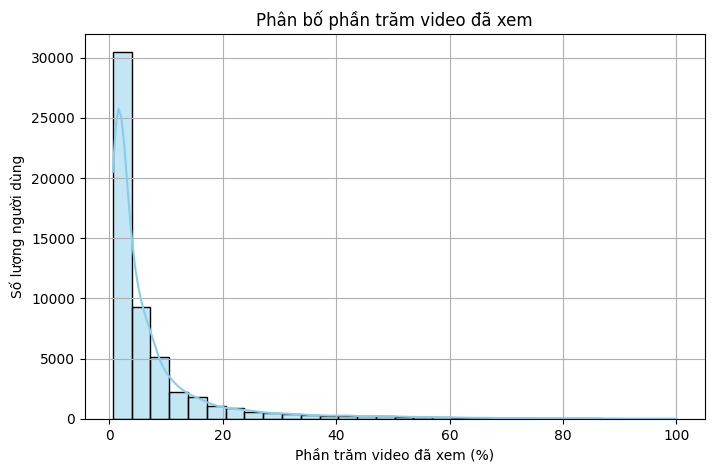

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


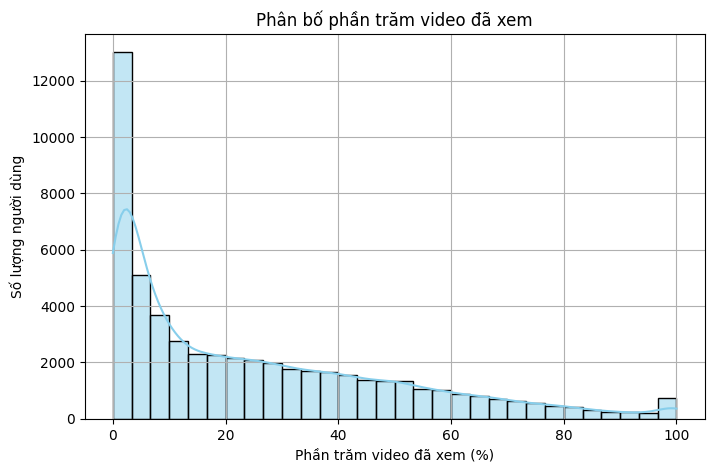

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển sang pandas
uv_df1 = uv_df.select(["video_watched_percentage"]).to_pandas()
uv_df2 = uv_df.select(["video_percentage_watch_time"]).to_pandas()

# Vẽ histogram
plt.figure(figsize=(8, 5))
sns.histplot(uv_df1["video_watched_percentage"], bins=30, kde=True, color='skyblue')
plt.title("Phân bố phần trăm video đã xem")
plt.xlabel("Phần trăm video đã xem (%)")
plt.ylabel("Số lượng người dùng")
plt.grid(True)
plt.show()

# Vẽ histogram
plt.figure(figsize=(8, 5))
sns.histplot(uv_df2["video_percentage_watch_time"], bins=30, kde=True, color='skyblue')
plt.title("Phân bố phần trăm video đã xem")
plt.xlabel("Phần trăm video đã xem (%)")
plt.ylabel("Số lượng người dùng")
plt.grid(True)
plt.show()


In [26]:
# import polars as pl

# # Giả sử bạn đang có DataFrame Pandas tên là `uv_df_pd`
# uv_df = pl.from_pandas(uv_df)


num_rows_over_100 = uv_df.filter(pl.col("video_percentage_watch_time") > 100).height
num_rows_over_100

0

In [27]:
uv_df.columns

['user_id',
 'course_of_watched_video',
 'seq',
 'filtered_seq',
 'user_videos_id',
 'ccid',
 'duration_seg',
 'segments_list',
 'start_points',
 'end_points',
 'speed',
 'watch_time_seg',
 'video_length',
 'enroll_time',
 'video_watch_count',
 'unique_course',
 'total_videos_for_user',
 'video_watched_percentage',
 'max_watch_per_video',
 'watch_percentages',
 'video_percentage_watch_time']

In [28]:
# TÍNH TRUNG BÌNH TỐC ĐỘ XEM

uv_df = uv_df.with_columns([
    pl.col("speed").map_elements(
        lambda outer: float(
            sum([sum(inner) / len(inner) if len(inner) > 0 else 0.0 for inner in outer])
        ) / max(len(outer), 1)
    ).alias("video_speed_avg")
])

# TÍNH THỜI GIAN NGẮT QUÃNG GIỮA CÁC LẦN XEM, TRUNG BÌNH VÀ STD
#
uv_df = uv_df.with_columns([
    pl.struct(["start_points", "end_points"]).map_elements(
        lambda row: [
            [s_next - e_curr for s_next, e_curr in zip(s[1:], e[:-1])] if len(s) > 1 else [0.0]
            for s, e in zip(row["start_points"], row["end_points"])
        ]
    ).alias("video_time_between_views")
])

uv_df = uv_df.with_columns([
    # Tính trung bình
    pl.col("video_time_between_views").map_elements(
        lambda outer: float(sum([sum(inner) for inner in outer], 0.0)) / max(sum([len(inner) for inner in outer]), 1)
    ).alias("video_time_between_views_avg"),

    # Tính độ lệch chuẩn
    pl.col("video_time_between_views").map_elements(
        lambda outer: (
            (lambda flat: float(np.std(flat, ddof=1)) if len(flat) > 1 else 0.0)(
                [x for inner in outer for x in inner]
            )
        )
    ).alias("video_time_between_views_std")
])

uv_df[:2, :]

/tmp/ipykernel_31/1338660304.py:3: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  uv_df = uv_df.with_columns([
/tmp/ipykernel_31/1338660304.py:13: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  uv_df = uv_df.with_columns([
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


user_id,course_of_watched_video,seq,filtered_seq,user_videos_id,ccid,duration_seg,segments_list,start_points,end_points,speed,watch_time_seg,video_length,enroll_time,video_watch_count,unique_course,total_videos_for_user,video_watched_percentage,max_watch_per_video,watch_percentages,video_percentage_watch_time,video_speed_avg,video_time_between_views,video_time_between_views_avg,video_time_between_views_std
str,str,list[struct[2]],list[struct[2]],list[str],list[str],list[list[f64]],list[list[struct[4]]],list[list[f64]],list[list[f64]],list[list[f64]],list[list[f64]],list[f64],list[str],u32,str,i64,f64,list[f64],list[f64],f64,f64,list[list[f64]],f64,f64
"""U_522658""","""1756063""","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[""V_4412433"", ""V_4412433""]","[""F00C3AA40CBDCC089C33DC5901307461"", ""F00C3AA40CBDCC089C33DC5901307461""]","[[9.827], [25.24, 14.838, … 3.361]]","[[{3.653,13.48,1.0,1598974140}], [{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]]","[[3.653], [4.061, 9.259, … 64.119]]","[[13.48], [29.301, 24.097, … 67.48]]","[[1.0], [1.0, 1.0, … 1.0]]","[[9.827], [25.24, 14.838, … 3.361]]","[61.45, 61.45]","[""2020-09-01 18:04:15"", ""2020-09-01 18:04:15""]",1,"""1756063""",76,1.315789,"[9.827, 45.074]","[15.991863, 73.350692]",44.671277,1.0,"[[0.0], [-20.042, 5.103, … 15.159]]",-12.0162,29.882198
"""U_705317""","""697791""","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358742"",[{16.0,26.0,2.0,1585055681}, {86.0,96.0,2.0,1585055716}, … {769.0,779.0,2.0,1585057121}]}]","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358744"",[{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]}]","[""V_1358727"", ""V_1358729"", … ""V_1358744""]","[""F99D8EB7087905E49C33DC5901307461"", ""4313C6A7010D905D9C33DC5901307461"", … ""5198291D2EFBB0229C33DC5901307461""]","[[10.0, 10.0, 10.0], [10.0, 10.0, 10.0], … [10.0, 10.0]]","[[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}], [{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}], … [{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]]","[[6.0, 306.0, 455.0], [76.0, 96.0, 333.0], … [73.0, 123.0]]","[[16.0, 316.0, 465.0], [86.0, 106.0, 343.0], … [83.0, 133.0]]","[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0], … [2.0, 2.0]]","[[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], … [5.0, 5.0]]","[468.16, 709.48, … 348.84]","[""2020-03-24 18:39:18"", ""2020-03-24 18:39:18"", … ""2020-03-24 18:39:18""]",7,"""697791""",114,6.140351,"[10.0, 10.0, … 10.0]","[2.136022, 1.409483, … 2.866644]",2.598964,2.0,"[[290.0, 139.0], [10.0, 227.0], … [40.0]]",91.809524,78.991531


In [29]:
# tính số lần ngắt quãng (pause) mà user đã có 
uv_df = uv_df.with_columns([
    pl.col("start_points")
      .map_elements(lambda list_of_lists: sum(len(sublist) for sublist in list_of_lists), return_dtype=pl.Int64)
      .alias("video_pause_count")
])

# tính trung bình số lần ngắt quãng là cột video_pause_avg, 
# tính độ lệch chuẩn số lần ngắt quãng là cột video_pause_std,
uv_df = uv_df.with_columns([
    # Trung bình số lần ngắt quãng mỗi video
    pl.col("start_points")
      .map_elements(lambda list_of_lists: (
          sum(len(sublist) for sublist in list_of_lists) / len(list_of_lists)
          if len(list_of_lists) > 0 else 0
      ), return_dtype=pl.Float64)
      .alias("video_pause_avg"),

    # Độ lệch chuẩn số lần ngắt quãng mỗi video, thay null bằng 0.0
    pl.col("start_points")
      .map_elements(lambda list_of_lists: (
          float(pl.Series([len(sublist) for sublist in list_of_lists]).std())
          if len(list_of_lists) > 1 else 0.0  # ít nhất phải có 2 video mới tính std được
      ), return_dtype=pl.Float64)
      .alias("video_pause_std"),
])

uv_df[:2, :]

user_id,course_of_watched_video,seq,filtered_seq,user_videos_id,ccid,duration_seg,segments_list,start_points,end_points,speed,watch_time_seg,video_length,enroll_time,video_watch_count,unique_course,total_videos_for_user,video_watched_percentage,max_watch_per_video,watch_percentages,video_percentage_watch_time,video_speed_avg,video_time_between_views,video_time_between_views_avg,video_time_between_views_std,video_pause_count,video_pause_avg,video_pause_std
str,str,list[struct[2]],list[struct[2]],list[str],list[str],list[list[f64]],list[list[struct[4]]],list[list[f64]],list[list[f64]],list[list[f64]],list[list[f64]],list[f64],list[str],u32,str,i64,f64,list[f64],list[f64],f64,f64,list[list[f64]],f64,f64,i64,f64,f64
"""U_522658""","""1756063""","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[""V_4412433"", ""V_4412433""]","[""F00C3AA40CBDCC089C33DC5901307461"", ""F00C3AA40CBDCC089C33DC5901307461""]","[[9.827], [25.24, 14.838, … 3.361]]","[[{3.653,13.48,1.0,1598974140}], [{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]]","[[3.653], [4.061, 9.259, … 64.119]]","[[13.48], [29.301, 24.097, … 67.48]]","[[1.0], [1.0, 1.0, … 1.0]]","[[9.827], [25.24, 14.838, … 3.361]]","[61.45, 61.45]","[""2020-09-01 18:04:15"", ""2020-09-01 18:04:15""]",1,"""1756063""",76,1.315789,"[9.827, 45.074]","[15.991863, 73.350692]",44.671277,1.0,"[[0.0], [-20.042, 5.103, … 15.159]]",-12.0162,29.882198,6,3.0,2.828427
"""U_705317""","""697791""","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358742"",[{16.0,26.0,2.0,1585055681}, {86.0,96.0,2.0,1585055716}, … {769.0,779.0,2.0,1585057121}]}]","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358744"",[{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]}]","[""V_1358727"", ""V_1358729"", … ""V_1358744""]","[""F99D8EB7087905E49C33DC5901307461"", ""4313C6A7010D905D9C33DC5901307461"", … ""5198291D2EFBB0229C33DC5901307461""]","[[10.0, 10.0, 10.0], [10.0, 10.0, 10.0], … [10.0, 10.0]]","[[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}], [{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}], … [{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]]","[[6.0, 306.0, 455.0], [76.0, 96.0, 333.0], … [73.0, 123.0]]","[[16.0, 316.0, 465.0], [86.0, 106.0, 343.0], … [83.0, 133.0]]","[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0], … [2.0, 2.0]]","[[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], … [5.0, 5.0]]","[468.16, 709.48, … 348.84]","[""2020-03-24 18:39:18"", ""2020-03-24 18:39:18"", … ""2020-03-24 18:39:18""]",7,"""697791""",114,6.140351,"[10.0, 10.0, … 10.0]","[2.136022, 1.409483, … 2.866644]",2.598964,2.0,"[[290.0, 139.0], [10.0, 227.0], … [40.0]]",91.809524,78.991531,27,3.857143,2.734262


In [30]:
# TÍNH TRUNG BÌNH, STD SỐ LẦN XEM LẠI
def rewatch_counts(start_lists, end_lists):
    counts = []
    for starts, ends in zip(start_lists, end_lists):
        count = 0
        for i in range(1, len(starts)):
            if starts[i] < ends[i - 1]:
                count += 1
        counts.append(count)
    return counts

uv_df = uv_df.with_columns([
    pl.struct(["start_points", "end_points"])
      .map_elements(lambda x: rewatch_counts(x["start_points"], x["end_points"]))
      .alias("video_rewatch_count")
])

uv_df = uv_df.with_columns([
    pl.col("video_rewatch_count")
      .list.eval(pl.element().mean())
      .list.first()
      .alias("video_rewatch_avg"),

    pl.col("video_rewatch_count")
      .list.eval(pl.element().std(ddof=1))
      .list.first()
      .fill_null(0.0)
      .alias("video_rewatch_std"),
])

uv_df[:2, :]

/tmp/ipykernel_31/545875855.py:12: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  uv_df = uv_df.with_columns([


user_id,course_of_watched_video,seq,filtered_seq,user_videos_id,ccid,duration_seg,segments_list,start_points,end_points,speed,watch_time_seg,video_length,enroll_time,video_watch_count,unique_course,total_videos_for_user,video_watched_percentage,max_watch_per_video,watch_percentages,video_percentage_watch_time,video_speed_avg,video_time_between_views,video_time_between_views_avg,video_time_between_views_std,video_pause_count,video_pause_avg,video_pause_std,video_rewatch_count,video_rewatch_avg,video_rewatch_std
str,str,list[struct[2]],list[struct[2]],list[str],list[str],list[list[f64]],list[list[struct[4]]],list[list[f64]],list[list[f64]],list[list[f64]],list[list[f64]],list[f64],list[str],u32,str,i64,f64,list[f64],list[f64],f64,f64,list[list[f64]],f64,f64,i64,f64,f64,list[i64],f64,f64
"""U_522658""","""1756063""","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[""V_4412433"", ""V_4412433""]","[""F00C3AA40CBDCC089C33DC5901307461"", ""F00C3AA40CBDCC089C33DC5901307461""]","[[9.827], [25.24, 14.838, … 3.361]]","[[{3.653,13.48,1.0,1598974140}], [{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]]","[[3.653], [4.061, 9.259, … 64.119]]","[[13.48], [29.301, 24.097, … 67.48]]","[[1.0], [1.0, 1.0, … 1.0]]","[[9.827], [25.24, 14.838, … 3.361]]","[61.45, 61.45]","[""2020-09-01 18:04:15"", ""2020-09-01 18:04:15""]",1,"""1756063""",76,1.315789,"[9.827, 45.074]","[15.991863, 73.350692]",44.671277,1.0,"[[0.0], [-20.042, 5.103, … 15.159]]",-12.0162,29.882198,6,3.0,2.828427,"[0, 2]",1.0,1.414214
"""U_705317""","""697791""","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358742"",[{16.0,26.0,2.0,1585055681}, {86.0,96.0,2.0,1585055716}, … {769.0,779.0,2.0,1585057121}]}]","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358744"",[{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]}]","[""V_1358727"", ""V_1358729"", … ""V_1358744""]","[""F99D8EB7087905E49C33DC5901307461"", ""4313C6A7010D905D9C33DC5901307461"", … ""5198291D2EFBB0229C33DC5901307461""]","[[10.0, 10.0, 10.0], [10.0, 10.0, 10.0], … [10.0, 10.0]]","[[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}], [{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}], … [{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]]","[[6.0, 306.0, 455.0], [76.0, 96.0, 333.0], … [73.0, 123.0]]","[[16.0, 316.0, 465.0], [86.0, 106.0, 343.0], … [83.0, 133.0]]","[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0], … [2.0, 2.0]]","[[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], … [5.0, 5.0]]","[468.16, 709.48, … 348.84]","[""2020-03-24 18:39:18"", ""2020-03-24 18:39:18"", … ""2020-03-24 18:39:18""]",7,"""697791""",114,6.140351,"[10.0, 10.0, … 10.0]","[2.136022, 1.409483, … 2.866644]",2.598964,2.0,"[[290.0, 139.0], [10.0, 227.0], … [40.0]]",91.809524,78.991531,27,3.857143,2.734262,"[0, 0, … 0]",0.0,0.0


In [31]:
# TÍNH ENTROPY CỦA KHOẢNG THỜI GIAN XEM

def entropy_single(duration_list):
    total = sum(duration_list)
    if total == 0 or len(duration_list) == 0:
        return 0.0
    probs = [d / total for d in duration_list]
    return sum([-p * np.log2(p) if p > 0 else 0.0 for p in probs])

# Áp dụng cho từng video trong danh sách duration_seg
uv_df = uv_df.with_columns([
    pl.col("duration_seg").map_elements(
        lambda video_durations: [entropy_single(seg) for seg in video_durations]
    ).alias("ent_seg")  # đây là entropy của từng video
])

# Tính trung bình tất cả entropy từ các list trong ent_seg và thêm làm cột entropy_time
# Tính trung bình của các list trong ent_seg
uv_df = uv_df.with_columns(
    pl.col("ent_seg").list.mean().alias("entropy_time")
)

uv_df[:2, :]

/tmp/ipykernel_31/4196240759.py:11: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  uv_df = uv_df.with_columns([


user_id,course_of_watched_video,seq,filtered_seq,user_videos_id,ccid,duration_seg,segments_list,start_points,end_points,speed,watch_time_seg,video_length,enroll_time,video_watch_count,unique_course,total_videos_for_user,video_watched_percentage,max_watch_per_video,watch_percentages,video_percentage_watch_time,video_speed_avg,video_time_between_views,video_time_between_views_avg,video_time_between_views_std,video_pause_count,video_pause_avg,video_pause_std,video_rewatch_count,video_rewatch_avg,video_rewatch_std,ent_seg,entropy_time
str,str,list[struct[2]],list[struct[2]],list[str],list[str],list[list[f64]],list[list[struct[4]]],list[list[f64]],list[list[f64]],list[list[f64]],list[list[f64]],list[f64],list[str],u32,str,i64,f64,list[f64],list[f64],f64,f64,list[list[f64]],f64,f64,i64,f64,f64,list[i64],f64,f64,list[f64],f64
"""U_522658""","""1756063""","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[{""V_4412433"",[{3.653,13.48,1.0,1598974140}]}, {""V_4412433"",[{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]}]","[""V_4412433"", ""V_4412433""]","[""F00C3AA40CBDCC089C33DC5901307461"", ""F00C3AA40CBDCC089C33DC5901307461""]","[[9.827], [25.24, 14.838, … 3.361]]","[[{3.653,13.48,1.0,1598974140}], [{4.061,29.301,1.0,1598974175}, {9.259,24.097,1.0,1598974205}, … {64.119,67.48,1.0,1598974357}]]","[[3.653], [4.061, 9.259, … 64.119]]","[[13.48], [29.301, 24.097, … 67.48]]","[[1.0], [1.0, 1.0, … 1.0]]","[[9.827], [25.24, 14.838, … 3.361]]","[61.45, 61.45]","[""2020-09-01 18:04:15"", ""2020-09-01 18:04:15""]",1,"""1756063""",76,1.315789,"[9.827, 45.074]","[15.991863, 73.350692]",44.671277,1.0,"[[0.0], [-20.042, 5.103, … 15.159]]",-12.0162,29.882198,6,3.0,2.828427,"[0, 2]",1.0,1.414214,"[0.0, 2.023177]",1.011589
"""U_705317""","""697791""","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358742"",[{16.0,26.0,2.0,1585055681}, {86.0,96.0,2.0,1585055716}, … {769.0,779.0,2.0,1585057121}]}]","[{""V_1358727"",[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}]}, {""V_1358729"",[{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}]}, … {""V_1358744"",[{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]}]","[""V_1358727"", ""V_1358729"", … ""V_1358744""]","[""F99D8EB7087905E49C33DC5901307461"", ""4313C6A7010D905D9C33DC5901307461"", … ""5198291D2EFBB0229C33DC5901307461""]","[[10.0, 10.0, 10.0], [10.0, 10.0, 10.0], … [10.0, 10.0]]","[[{6.0,16.0,2.0,1585046398}, {306.0,316.0,2.0,1585046548}, {455.0,465.0,2.0,1585046623}], [{76.0,86.0,2.0,1585046679}, {96.0,106.0,2.0,1585046689}, {333.0,343.0,2.0,1585046889}], … [{73.0,83.0,2.0,1585057512}, {123.0,133.0,2.0,1585057537}]]","[[6.0, 306.0, 455.0], [76.0, 96.0, 333.0], … [73.0, 123.0]]","[[16.0, 316.0, 465.0], [86.0, 106.0, 343.0], … [83.0, 133.0]]","[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0], … [2.0, 2.0]]","[[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], … [5.0, 5.0]]","[468.16, 709.48, … 348.84]","[""2020-03-24 18:39:18"", ""2020-03-24 18:39:18"", … ""2020-03-24 18:39:18""]",7,"""697791""",114,6.140351,"[10.0, 10.0, … 10.0]","[2.136022, 1.409483, … 2.866644]",2.598964,2.0,"[[290.0, 139.0], [10.0, 227.0], … [40.0]]",91.809524,78.991531,27,3.857143,2.734262,"[0, 0, … 0]",0.0,0.0,"[1.584963, 1.584963, … 1.0]",1.628351


In [32]:
uv_df.columns

['user_id',
 'course_of_watched_video',
 'seq',
 'filtered_seq',
 'user_videos_id',
 'ccid',
 'duration_seg',
 'segments_list',
 'start_points',
 'end_points',
 'speed',
 'watch_time_seg',
 'video_length',
 'enroll_time',
 'video_watch_count',
 'unique_course',
 'total_videos_for_user',
 'video_watched_percentage',
 'max_watch_per_video',
 'watch_percentages',
 'video_percentage_watch_time',
 'video_speed_avg',
 'video_time_between_views',
 'video_time_between_views_avg',
 'video_time_between_views_std',
 'video_pause_count',
 'video_pause_avg',
 'video_pause_std',
 'video_rewatch_count',
 'video_rewatch_avg',
 'video_rewatch_std',
 'ent_seg',
 'entropy_time']

In [33]:
uv_df_filtered = uv_df.select([
 'user_id',
 'ccid',
 'video_watch_count',
 'unique_course',
 'total_videos_for_user',
 'video_watched_percentage',
 'video_percentage_watch_time',
 'video_speed_avg',
 'video_time_between_views',
 'video_time_between_views_avg',
 'video_time_between_views_std',
 'video_pause_count',
 'video_pause_avg',
 'video_pause_std',
 'video_rewatch_count',
 'video_rewatch_avg',
 'video_rewatch_std',
 'entropy_time'])
uv_df_filtered[:2, :]

user_id,ccid,video_watch_count,unique_course,total_videos_for_user,video_watched_percentage,video_percentage_watch_time,video_speed_avg,video_time_between_views,video_time_between_views_avg,video_time_between_views_std,video_pause_count,video_pause_avg,video_pause_std,video_rewatch_count,video_rewatch_avg,video_rewatch_std,entropy_time
str,list[str],u32,str,i64,f64,f64,f64,list[list[f64]],f64,f64,i64,f64,f64,list[i64],f64,f64,f64
"""U_522658""","[""F00C3AA40CBDCC089C33DC5901307461"", ""F00C3AA40CBDCC089C33DC5901307461""]",1,"""1756063""",76,1.315789,44.671277,1.0,"[[0.0], [-20.042, 5.103, … 15.159]]",-12.0162,29.882198,6,3.0,2.828427,"[0, 2]",1.0,1.414214,1.011589
"""U_705317""","[""F99D8EB7087905E49C33DC5901307461"", ""4313C6A7010D905D9C33DC5901307461"", … ""5198291D2EFBB0229C33DC5901307461""]",7,"""697791""",114,6.140351,2.598964,2.0,"[[290.0, 139.0], [10.0, 227.0], … [40.0]]",91.809524,78.991531,27,3.857143,2.734262,"[0, 0, … 0]",0.0,0.0,1.628351


In [34]:
uv_df_filtered.shape

(54404, 18)

In [35]:
df_all_phases

user_id,video_watch_count_1,video_watched_percentage_1,video_percentage_watch_time_1,video_pause_count_1,video_pause_avg_1,video_pause_std_1,video_rewatch_count_1,video_rewatch_avg_1,video_rewatch_std_1,video_time_between_views_1,video_time_between_views_avg_1,video_time_between_views_std_1,video_speed_avg_1,entropy_time_1,video_watch_count_2,video_watched_percentage_2,video_percentage_watch_time_2,video_pause_count_2,video_pause_avg_2,video_pause_std_2,video_rewatch_count_2,video_rewatch_avg_2,video_rewatch_std_2,video_time_between_views_2,video_time_between_views_avg_2,video_time_between_views_std_2,video_speed_avg_2,entropy_time_2,video_watch_count_3,video_watched_percentage_3,video_percentage_watch_time_3,video_pause_count_3,video_pause_avg_3,video_pause_std_3,video_rewatch_count_3,video_rewatch_avg_3,video_rewatch_std_3,video_time_between_views_3,video_time_between_views_avg_3,video_time_between_views_std_3,video_speed_avg_3,entropy_time_3,video_watch_count_4,video_watched_percentage_4,video_percentage_watch_time_4,video_pause_count_4,video_pause_avg_4,video_pause_std_4,video_rewatch_count_4,video_rewatch_avg_4,video_rewatch_std_4,video_time_between_views_4,video_time_between_views_avg_4,video_time_between_views_std_4,video_speed_avg_4,entropy_time_4
str,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64
"""U_24869016""",1,2.380952,4.451426,2,2.0,0.0,[1],1.0,0.0,[[-1.1]],-1.1,0.0,1.0,0.745353,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""U_28951047""",1,1.162791,13.509049,5,5.0,0.0,[0],0.0,0.0,"[[5.067, 390.008, … 5.006]]",101.272,192.490669,1.0,2.045522,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""U_28921558""",3,2.631579,7.097321,7,2.333333,1.527525,"[0, 0, 0]",0.0,0.0,"[[0.0], [511.6], [97.5, 278.1, 138.65]]",205.17,198.324606,1.479167,0.862452,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,6,5.263158,6.997906,8,1.333333,0.516398,"[0, 0, … 0]",0.0,0.0,"[[0.0], [0.0], … [82.85]]",38.05,62.182007,1.25,0.333055
"""U_32886973""",2,3.278689,70.650372,8,4.0,0.0,"[0, 0]",0.0,0.0,"[[10.0, 10.0, 10.0], [10.0, 10.0, 10.0]]",10.0,0.0,1.0,1.069054,5,8.196721,45.251814,7,1.0,0.0,"[0, 0, … 0]",0.0,0.0,"[[0.0], [0.0], … [0.0]]",0.0,0.0,1.714286,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""U_2152027""",4,3.508772,18.075015,5,1.0,0.0,"[0, 0, … 0]",0.0,0.0,"[[0.0], [0.0], … [0.0]]",0.0,0.0,2.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""U_32881303""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4,6.557377,59.732301,6,1.5,0.57735,"[0, 0, … 0]",0.0,0.0,"[[0.0], [0.0], … [5.065]]",1.9535,2.445852,1.0,0.425883
"""U_31433129""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,1.

### Tổng hợp df chung của user_video và df của 4 phase

In [36]:
# Join, giữ user_id từ df_all_phases
joined_df = uv_df_filtered.join(df_all_phases, on="user_id", how="right")

# Đảm bảo cột user_id đứng đầu
cols = ["user_id"] + [col for col in joined_df.columns if col != "user_id"]
joined_df = joined_df.select(cols)
joined_df[:2, :]

user_id,ccid,video_watch_count,unique_course,total_videos_for_user,video_watched_percentage,video_percentage_watch_time,video_speed_avg,video_time_between_views,video_time_between_views_avg,video_time_between_views_std,video_pause_count,video_pause_avg,video_pause_std,video_rewatch_count,video_rewatch_avg,video_rewatch_std,entropy_time,video_watch_count_1,video_watched_percentage_1,video_percentage_watch_time_1,video_pause_count_1,video_pause_avg_1,video_pause_std_1,video_rewatch_count_1,video_rewatch_avg_1,video_rewatch_std_1,video_time_between_views_1,video_time_between_views_avg_1,video_time_between_views_std_1,video_speed_avg_1,entropy_time_1,video_watch_count_2,video_watched_percentage_2,video_percentage_watch_time_2,video_pause_count_2,video_pause_avg_2,video_pause_std_2,video_rewatch_count_2,video_rewatch_avg_2,video_rewatch_std_2,video_time_between_views_2,video_time_between_views_avg_2,video_time_between_views_std_2,video_speed_avg_2,entropy_time_2,video_watch_count_3,video_watched_percentage_3,video_percentage_watch_time_3,video_pause_count_3,video_pause_avg_3,video_pause_std_3,video_rewatch_count_3,video_rewatch_avg_3,video_rewatch_std_3,video_time_between_views_3,video_time_between_views_avg_3,video_time_between_views_std_3,video_speed_avg_3,entropy_time_3,video_watch_count_4,video_watched_percentage_4,video_percentage_watch_time_4,video_pause_count_4,video_pause_avg_4,video_pause_std_4,video_rewatch_count_4,video_rewatch_avg_4,video_rewatch_std_4,video_time_between_views_4,video_time_between_views_avg_4,video_time_between_views_std_4,video_speed_avg_4,entropy_time_4
str,list[str],u32,str,i64,f64,f64,f64,list[list[f64]],f64,f64,i64,f64,f64,list[i64],f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64
"""U_24869016""","[""1E8AA28CBDD0030B9C33DC5901307461""]",1,"""754135""",42,2.380952,4.451426,1.0,[[-1.1]],-1.1,0.0,2,2.0,0.0,[1],1.0,0.0,0.745353,1,2.380952,4.451426,2,2.0,0.0,[1],1.0,0.0,[[-1.1]],-1.1,0.0,1.0,0.745353,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""U_28951047""","[""DAB90BC430AE81299C33DC5901307461""]",1,"""1822804""",86,1.162791,13.509049,1.0,"[[5.067, 390.008, … 5.006]]",101.272,192.490669,5,5.0,0.0,[0],0.0,0.0,2.045522,1,1.162791,13.509049,5,5.0,0.0,[0],0.0,0.0,"[[5.067, 390.008, … 5.006]]",101.272,192.490669,1.0,2.045522,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [37]:
# Đếm số lượng null theo từng cột trong joined_df
null_counts_per_column = joined_df.select(
    [pl.col(c).is_null().sum().alias(c) for c in df_all_phases.columns]
)

null_counts_per_column


user_id,video_watch_count_1,video_watched_percentage_1,video_percentage_watch_time_1,video_pause_count_1,video_pause_avg_1,video_pause_std_1,video_rewatch_count_1,video_rewatch_avg_1,video_rewatch_std_1,video_time_between_views_1,video_time_between_views_avg_1,video_time_between_views_std_1,video_speed_avg_1,entropy_time_1,video_watch_count_2,video_watched_percentage_2,video_percentage_watch_time_2,video_pause_count_2,video_pause_avg_2,video_pause_std_2,video_rewatch_count_2,video_rewatch_avg_2,video_rewatch_std_2,video_time_between_views_2,video_time_between_views_avg_2,video_time_between_views_std_2,video_speed_avg_2,entropy_time_2,video_watch_count_3,video_watched_percentage_3,video_percentage_watch_time_3,video_pause_count_3,video_pause_avg_3,video_pause_std_3,video_rewatch_count_3,video_rewatch_avg_3,video_rewatch_std_3,video_time_between_views_3,video_time_between_views_avg_3,video_time_between_views_std_3,video_speed_avg_3,entropy_time_3,video_watch_count_4,video_watched_percentage_4,video_percentage_watch_time_4,video_pause_count_4,video_pause_avg_4,video_pause_std_4,video_rewatch_count_4,video_rewatch_avg_4,video_rewatch_std_4,video_time_between_views_4,video_time_between_views_avg_4,video_time_between_views_std_4,video_speed_avg_4,entropy_time_4
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,9740,9740,9740,9740,9740,9740,9740,9740,9740,9740,9740,9740,9740,9740,24163,24163,24163,24163,24163,24163,24163,24163,24163,24163,24163,24163,24163,24163,28676,28676,28676,28676,28676,28676,28676,28676,28676,28676,28676,28676,28676,28676,30876,30876,30876,30876,30876,30876,30876,30876,30876,30876,30876,30876,30876,30876


In [38]:
joined_df[10:20, :]

user_id,ccid,video_watch_count,unique_course,total_videos_for_user,video_watched_percentage,video_percentage_watch_time,video_speed_avg,video_time_between_views,video_time_between_views_avg,video_time_between_views_std,video_pause_count,video_pause_avg,video_pause_std,video_rewatch_count,video_rewatch_avg,video_rewatch_std,entropy_time,video_watch_count_1,video_watched_percentage_1,video_percentage_watch_time_1,video_pause_count_1,video_pause_avg_1,video_pause_std_1,video_rewatch_count_1,video_rewatch_avg_1,video_rewatch_std_1,video_time_between_views_1,video_time_between_views_avg_1,video_time_between_views_std_1,video_speed_avg_1,entropy_time_1,video_watch_count_2,video_watched_percentage_2,video_percentage_watch_time_2,video_pause_count_2,video_pause_avg_2,video_pause_std_2,video_rewatch_count_2,video_rewatch_avg_2,video_rewatch_std_2,video_time_between_views_2,video_time_between_views_avg_2,video_time_between_views_std_2,video_speed_avg_2,entropy_time_2,video_watch_count_3,video_watched_percentage_3,video_percentage_watch_time_3,video_pause_count_3,video_pause_avg_3,video_pause_std_3,video_rewatch_count_3,video_rewatch_avg_3,video_rewatch_std_3,video_time_between_views_3,video_time_between_views_avg_3,video_time_between_views_std_3,video_speed_avg_3,entropy_time_3,video_watch_count_4,video_watched_percentage_4,video_percentage_watch_time_4,video_pause_count_4,video_pause_avg_4,video_pause_std_4,video_rewatch_count_4,video_rewatch_avg_4,video_rewatch_std_4,video_time_between_views_4,video_time_between_views_avg_4,video_time_between_views_std_4,video_speed_avg_4,entropy_time_4
str,list[str],u32,str,i64,f64,f64,f64,list[list[f64]],f64,f64,i64,f64,f64,list[i64],f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64,u32,f64,f64,i64,f64,f64,list[i64],f64,f64,list[list[f64]],f64,f64,f64,f64
"""U_34387005""","[""38AC922D514A75A69C33DC5901307461"", ""97C1A1AF213873809C33DC5901307461"", … ""E693C5F717F85D3B9C33DC5901307461""]",5,"""936971""",38,13.157895,69.365636,1.7,"[[0.0], [0.0], … [0.0]]",-117.8722,263.570252,6,1.2,0.447214,"[0, 0, … 0]",0.2,0.447214,0.062183,5,13.157895,69.365636,6,1.2,0.447214,"[0, 0, … 0]",0.2,0.447214,"[[0.0], [0.0], … [0.0]]",-117.8722,263.570252,1.7,0.062183,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""U_14071774""","[""BB93EAEFD50EA3EF9C33DC5901307461"", ""3F512B6925B6CEDE9C33DC5901307461"", … ""03E86606174DCDAB9C33DC5901307461""]",9,"""681760""",36,25.0,26.542369,1.117657,"[[0.0, -13.9], [0.0], … [3.1]]",31.781429,133.365761,44,3.384615,2.814796,"[1, 0, … 0]",0.461538,0.518875,0.993962,9,25.0,26.542369,44,3.384615,2.814796,"[1, 0, … 0]",0.461538,0.518875,"[[0.0, -13.9], [0.0], … [3.1]]",31.781429,133.365761,1.117657,0.993962,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""U_17861694""","[""193855E7E165B37B9C33DC5901307461"", ""877D32C8CD2606009C33DC5901307461"", … ""D0206F0854051FB09C33DC5901307461""]",8,"""697791""",114,7.017544,19.518794,1.037037,"[[8.5, 20.3], [0.0], … [5.7, -7.4, … 30.4]]",59.871053,93.801486,24,2.666667,1.870829,"[0, 0, … 1]",0.222222,0.440959,0.87553,5,4.385965,14.631762,19,3.166667,2.041241,"[0, 1, … 1]",0.333333,0.516398,"[[0.0], [48.45, 35.2, … 240.5], … [5.7, -7.4, … 30.4]]",73.916667,101.433936,1.041667,1.111741,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""U_32028163""","[""CDAC1A9F14B19C2F9C33DC5901307461"",

In [39]:
df_all_phases.write_parquet('uv_all_phases')
joined_df.write_parquet('uv_all_phases_final')
uv_df_filtered.write_parquet('uv_general')